| Subject   |     ICC103      |
|:----------|:-------------|
| **Assignment  ** |   |
| **Number of activities** |  2 |
| **Class of assignment** |  workshop  |
| **Assigment date** | November the 13th, 2019 |
| **Due date** | November the 15th, 2019  |
| **Modality** | Pair programming |
| **Topic** | Experimental performance evaluation |
| **Student enrollment Id's** | **Edit this field** |
| **Authors**| Dr. Adán Hirales Carbajal |
| **Last update date** | November the 6th, 2019 |


# Experimental performance evaluation


Assume two sorting algorithms quicksort and heapsort. Both have equal asymptotic growth of θ(n log⁡n), consequently, they are equally good. However, does such statement holds when mapped to a real machine architecture? In this notebook, we will address this question by evaluating their performance experimentally. The objective of the notebook is to evaluate the performance of algorithms. To do so, tasks required to gather data and to analyze it are explained. 

Before proceding, since you will be working on a remote server, it is convinient to understand the following **terminology**:
- **Process**,  is the instance of a computer program that is being executed by one or many threads.  
- **working set**, is the set of pages in the virtual address space of the process that are currently resident in physical memory.The working set can be divided into code working set and data working set. When a process starts it is unlikely to be in the local processor cache, so a context-switch causes a flurry of cache misses, and may run slow until it builds its working set. However, if data is not found in cache, it may also produce caches misses and context switch is produces, slowing down execution.
- **Host**, remote server that provides one or more services, for example: processing, storage, http content, users, etc.
- **Root directory**, is the user's home directory on the host. On Unix you print your home directory by executing echo \$HOME.  
- **likwid perfctr**, is a library that allows access to CPU performance counters. It was developed by Roehl,T., Treibig, J ., Hager, G ., Wellein, and G. See [lidwid](https://github.com/RRZE-HPC/likwid/wiki). 
- **[MobaXterm](https://mobaxterm.mobatek.net/demo.html)**, is terminal which enables connection to a host server.

For this notebook, likwid was install in a Dell PowerEdge server. If you plan to conduct instrumentation on your machine, unsure gcc, cmake, and likwid is install. Performance profiling libraries, such as likwid and many others, may induce runtime overhead due to instrumentation. Thus, runtime may be smaller if no profiling is conducted. Profiling helps understand how your program uses machine resources.

In what follows, I will assume you have knowledge of the two sorting algorithms we will analyze. Thus, we will focus on:
- How to connect to the remote server.
- How to prepare a cmake project to produce two executables.
- How to generate sythectic workloads.
- Identify and understand what machine resources can be instrumented.
- Automation of the instrumentation process.
- Plotting and insterpretation of resuts.

You may download or clone this workbook from [unit_testing_with_cmake/performance_evaluation](https://github.com/ahiralesc/unit_testing_with_cmake/tree/master/performance_evaluation) in github. After completing the notebook. You must replicate this procedure for your project (or assigment) and complete your poster.

##  How to connect to the remote server

<p>The remote server you will be working on IP is 10.10.11.101. Your network administrator will assign a user in due time. You must connect to it via ssh using a client of your preference (MobaXterm, putty, or other). The communication protocol you must use is ssh via port 22. See Fig. 1.</p>

<br><br><center><img src=img/img1.png hight=800, width=800>Fig. 1. MobaXTerm client.</img></center>

Specify your user name and press the ok button. The terminal window will request your password. You may chose to save your password to facilitate future logins. Once logged in the client will display a terminal window. See Fig. 2.

<br><br><center><img src=img/img2.png hight=800, width=800>Fig. 2. Terminal window.</img></center>

On the lower left corner of the client terminal contains a checkbox titled *follow terminal folder*, if selected, a change of directory in command prompt triggers a change of directory in *sftp* tab. window to drag and drop files from your machine to the server. Now is your turn! Connect to the remote server.

## How to prepare a cmake project to produce two executables

We know turn to the development environment. I have previously created a project working directory, which in the following example is show as a dot. The project directory structure is as follows.

In [4]:
%%bash
tree -L 2 .

.
├── analysis
├── build
├── CMakeLists.txt
├── img
│   ├── img1.png
│   ├── img2.png
│   ├── img3.jpg
│   ├── img3.png
│   └── img4.jpeg
├── include
│   ├── heapsort.hpp
│   └── quicksort.hpp
├── Lab_experimental_performance_eval.ipynb
├── Lab_Exp_Perf_Eval.tar
├── scripts
│   ├── evaluate.sh
│   └── workload.sh
├── src
│   ├── heapsort.cpp
│   └── quicksort.cpp
└── workload

7 directories, 14 files


The project subdirectories are:
- *analysis*, we will use this directory to store experimental results.
- *build*, it will contain the project configuration files, objects, and executable. Remember, these are built after running *cmake -Bbuild -H.*
- *include*, stores the project header files.
- *scripts*, a script that produces a syntectic workload (random numbers) and that automate the instrumentation process are stored here.
- *src*, stores the program source code.
- and *workload*, we will use this subdirectory to store the syntetic workloads that we will create.

For convenience, I have store the jupyter notebook on the project root (Lab_experimental_performance_eval.ipynb). The notebook is not required by the project build process. Note, it is likely that after cloning or dowloading file to your machine or account execution were not automatically granted to the scripts. Thus, you must do so as follows 

In [2]:
%%bash
chmod +x scripts/*.sh
ls -Al scripts/

total 8
-rwxrwxr-x 1 ahiralesc ahiralesc 502 Nov 11 07:33 evaluate.sh
-rwxrwxr-x 1 ahiralesc ahiralesc 133 Nov 12 09:13 workload.sh


Here, the *chmod +x* command granted *.sh files execution permission. In this example, the CMakeLists.txt file was modified so that it produces two executables.

In [6]:
%%bash
cat CMakeLists.txt

cmake_minimum_required(VERSION 3.5.1)
project(perfeval)

set(CMAKE_BUILD_TYPE Release)
set(CMAKE_CXX_STANDARD 11)
set(CMAKE_CXX_STANDARD_REQUIRED ON)

# Build type
if (NOT CMAKE_BUILD_TYPE AND NOT CMAKE_CONFIGURATION_TYPES)
    message(STATUS "Setting build type to 'Debug' as none was specified.")
    set(CMAKE_BUILD_TYPE Debug CACHE STRING "Choose the type of build." FORCE)
    # Set the possible values of build type for cmake-gui
    set_property(CACHE CMAKE_BUILD_TYPE PROPERTY STRINGS "Debug" "Release")
endif ()

# Header location
include_directories( include )

# Source location
set(quicksort_src src/quicksort.cpp)
set(heapsort_src src/heapsort.cpp)


# Compilation flags
if (CMAKE_COMPILER_IS_GNUCC)
    set (CMAKE_C_FLAGS "-D_REETRANT -Wall -Wextra -pedantic -Wno-long-long")
    if (CMAKE_BUILD_TYPE STREQUAL "Debug")
        set (CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -ggdb -O0")
    elseif( CMAKE_BUILD_TYPE STREQUAL "Release" )
        set (CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -DNDEBUG -O3 -f

Thus cmake is instructed to produce two binaries via the *set* and *add_executable instructions*. 

## How to generate sythectic workloads
We now proceed to create 10 files with random numbers with range of [0,100000000-1]. Random numbers are considerably large and may result in more computational work. Workload files are stored in the workload subdirectory.

In [10]:
%%bash
cat scripts/workload.sh

#!/bin/bash
awk -v n=$1 -v ofs=$2 'BEGIN {
    srand() #semilla
    for(i=1; i<=n; i++){
print int(rand()*100000000) > ofs;
    }
}'


In [5]:
%%bash
for i in {100000..1000000..100000}
    do 
      tfn=workload/"$i".txt              # creates the target filename
      ./scripts/workload.sh "$i" "$tfn"  # creates a workload with $i elements and stores it at file location $tfn
    done

In [6]:
%%bash
tree -L 1 workload/

workload/
├── 1000000.txt
├── 100000.txt
├── 200000.txt
├── 300000.txt
├── 400000.txt
├── 500000.txt
├── 600000.txt
├── 700000.txt
├── 800000.txt
└── 900000.txt

0 directories, 10 files


Lets see 10 lines from one of the workloads

In [62]:
%%bash
head -n 10 workload/100000.txt

92660373
58836853
89335348
53894343
89601189
51462450
20021630
41865974
29378634
8267277


## Identify and understand what machine resources can be instrumented.

In computers, hardware performance counters, or hardware counters are a set of special-purpose registers built into modern microprocessors to store the counts of hardware-related activities within computer systems. Advanced users often rely on those counters to conduct low-level performance analysis or tuning (wikipedia definition). You may seen them in action previously, for instance when you check the machine status on windows systems. See Fig. 3.

<br><br><center><img src=img/img3.png hight=800, width=800>Fig. 3. Windows process manager showing realtime profiling of CPU performance counters.</img></center>

In out testbed machine, memory, energy, and operation class performance counters can be instrumented. See the following table.

In [11]:
%%bash
likwid-perfctr -a

 Group name	Description
--------------------------------------------------------------------------------
  FLOPS_AVX	Packed AVX MFLOP/s
     MEM_SP	Overview of arithmetic and main memory performance
 UOPS_ISSUE	UOPs issueing
   TLB_DATA	L2 data TLB miss rate/ratio
     MEM_DP	Overview of arithmetic and main memory performance
    L2CACHE	L2 cache miss rate/ratio
   RECOVERY	Recovery duration
     ICACHE	Instruction cache miss rate/ratio
  UOPS_EXEC	UOPs execution
        QPI	QPI traffic between sockets
    L3CACHE	L3 cache miss rate/ratio
FALSE_SHARE	False sharing
   FLOPS_DP	Double Precision MFLOP/s
       UOPS	UOPs execution info
         L2	L2 cache bandwidth in MBytes/s
      CLOCK	Power and Energy consumption
         L3	L3 cache bandwidth in MBytes/s
     ENERGY	Power and Energy consumption
        MEM	Main memory bandwidth in MBytes/s
       DATA	Load to store ratio
     CACHES	Some data from the CBOXes
UOPS_RETIRE	UOPs retirement
       NUMA	Local and remote memory accesses
  T

Once a computational problem has been solved. The program runtime performance may be improved by analyzing its behaviour in memory and/or during I/O. Consider an ordinary workstation memory hierarchy


<br><br><center><img src=img/img4.jpeg hight=800, width=800>Fig. 4. PC memory hierarcgy.</img></center>

Initially, a program to execute is stored in secondary memory (hard-drive). When it is executed, its corresponding process is stored in primary memory. However, the process may not be completely stored in memory, as the data structures that it aggregates may be large compared to the amount of memory allocated to it by the operating system. Thus, some parts of the process may be left in secondary memory and some in primary memory. During the life time of the process execution it is fragmented further as its data and instructions are moved closer to cpu registers. As data or instructions may not fit completely in cache the program produce cache misses. In a way, this is not desirable, as the operating system has to fetch data or instructions that the program needs to continue execution. Thus, delaying the process execution. 

In our machine setup we have a tree level cache topology with sizes: 32Kb, 256Kb, and 10Mb. We can observe other machine characteristics by applying the *likwid-topology* command.

In [63]:
%%bash
likwid-topology

--------------------------------------------------------------------------------
CPU name:	Intel(R) Xeon(R) CPU E5-2403 0 @ 1.80GHz
CPU type:	Intel Xeon SandyBridge EN/EP processor
CPU stepping:	7
********************************************************************************
Hardware Thread Topology
********************************************************************************
Sockets:		1
Cores per socket:	4
Threads per core:	1
--------------------------------------------------------------------------------
HWThread	Thread		Core		Socket		Available
0		0		0		0		*
1		0		1		0		*
2		0		2		0		*
3		0		3		0		*
--------------------------------------------------------------------------------
Socket 0:		( 0 1 2 3 )
--------------------------------------------------------------------------------
********************************************************************************
Cache Topology
********************************************************************************
Level:			1
Size:			32 kB

In both out examples, the code size of both quicksort and heapsort is relatively small. Therefore, we do not expect to see to many cache misses. However, data size do exceed L2 and L1 sizes. Moreover, since multiprogramming is applied. Processes will not be allocated the complete cache size. See the file sizes as follows, 

In [7]:
%%bash
ls -al workload/

total 47788
drwxrwxr-x  2 ahiralesc ahiralesc    4096 Nov 14 07:55 .
drwxrwxr-x 10 ahiralesc ahiralesc    4096 Nov 14 07:55 ..
-rw-rw-r--  1 ahiralesc ahiralesc 8889129 Nov 14 07:55 1000000.txt
-rw-rw-r--  1 ahiralesc ahiralesc  888916 Nov 14 07:55 100000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 1777817 Nov 14 07:55 200000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 2666743 Nov 14 07:55 300000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 3555514 Nov 14 07:55 400000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 4444359 Nov 14 07:55 500000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 5333421 Nov 14 07:55 600000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 6222375 Nov 14 07:55 700000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 7111236 Nov 14 07:55 800000.txt
-rw-rw-r--  1 ahiralesc ahiralesc 8000182 Nov 14 07:55 900000.txt


The smallest size caches in the machine testbed are TLB_DATA and TLB_INSTR, these are equivalent to the cache memory in figure 3. To analyze the performance of the algorithms we will use *likwid-perfctr* command. Before instrumentation dont forget to compile your project and create the executables.

In [8]:
%%bash
cmake -Bbuild -H.

-- The C compiler identification is GNU 5.4.0
-- The CXX compiler identification is GNU 5.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /home/ahiralesc/mysrc/unit_testing_with_cmake/performance_evaluation/build


In [9]:
%%bash
cd build
pwd
make

/home/ahiralesc/mysrc/unit_testing_with_cmake/performance_evaluation/build
Scanning dependencies of target heapsort
[ 25%] Building CXX object CMakeFiles/heapsort.dir/src/heapsort.cpp.o
[ 50%] Linking CXX executable heapsort
[ 50%] Built target heapsort
Scanning dependencies of target quicksort
[ 75%] Building CXX object CMakeFiles/quicksort.dir/src/quicksort.cpp.o
[100%] Linking CXX executable quicksort
[100%] Built target quicksort


In [88]:
%%bash
for i in {100000..1000000..100000} 
do 
    sfn=workload/"$i".txt                 # source file name
    for metric in TLB_DATA TLB_INSTR; do  # metrics
        tfn=analysis/"$metric"_"$i".csv   # target file name
        likwid-perfctr -C 0-3 -g "$metric" -O ./build/quicksort workload/"$sfn" "$i" > "$tfn"
    done
done

In the previous cell, experiments are executed and instrumented. The resulting statistics are stored in the analysis subdirectory.

In [10]:
%%bash
ls -al analysis

total 88
drwxrwxr-x  2 ahiralesc ahiralesc 4096 Nov 12 11:04 .
drwxrwxr-x 10 ahiralesc ahiralesc 4096 Nov 13 07:27 ..
-rw-rw-r--  1 ahiralesc ahiralesc 2856 Nov 12 11:27 TLB_DATA_100000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2751 Nov 12 11:26 TLB_DATA_10000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2769 Nov 12 11:26 TLB_DATA_20000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2798 Nov 12 11:26 TLB_DATA_30000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2793 Nov 12 11:26 TLB_DATA_40000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2792 Nov 12 11:26 TLB_DATA_50000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2814 Nov 12 11:26 TLB_DATA_60000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2839 Nov 12 11:26 TLB_DATA_70000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2853 Nov 12 11:26 TLB_DATA_80000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2840 Nov 12 11:27 TLB_DATA_90000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2196 Nov 12 11:27 TLB_INSTR_100000.csv
-rw-rw-r--  1 ahiralesc ahiralesc 2138 Nov 12 11:26 TLB_INSTR_10000.csv
-rw-rw-r--  1 ahiralesc ah

Next, we want to analyze the TLB cache misses for each of the four cores in the machine. If you open one of the previous statistics files you will see that many parameters were instrumented for a the TLB_DATA and TLB_INSTR groups. For our analysis, we only care in uderstanding how many TLB misses occurred for data and instructions in each of the four cores. To do so, the following script extracts the desired data. See code comments.

In [28]:
%%bash
if [ -f analysis/tlb_data_misses.txt ]; then
    rm analysis/tlb_data_misses.txt
fi

for i in $(ls -AS analysis/TLB_DATA*); do
    stats=$(cat "$i" | grep "L1 DTLB load misses STAT"  | cut -d',' -f 2,3,4,5)
    xbase=${i##*/}        # extract the file name, i.e. TLB_DATA_100000.csv
    xpref=${xbase%.*}     # extract the file name witout extension i.e. TLB_DATA_100000
    length=${#xpref}      # get the size of the string
    wkl=${xpref:9:length} # get the substring corresponding to the workload size
    echo -e "$wkl, $stats" >> analysis/tlb_data_misses.txt
done

The parsed files extract the four cores TLB cache misses. The first column correspond to the log file size, columns two to the last containe the TLB cache miss counts. 

In [77]:
cat analysis/tlb_data_misses.txt

100000, 40663,4955,12993,10165.7500
80000, 201176,4015,175739,50294
90000, 56640,4647,19615,14160
70000, 49593,3778,28639,12398.2500
60000, 46932,3370,18220,11733
30000, 8002,1163,2501,2000.5000
40000, 9569,841,3418,2392.2500
50000, 11700,2811,3089,2925
20000, 4790,566,2358,1197.5000
10000, 3872,207,2156,968


In [1]:
import pandas as pd
%matplotlib inline

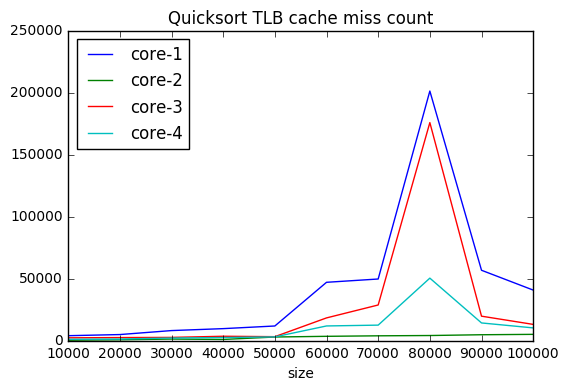

In [81]:
data = pd.read_csv("analysis/tlb_data_misses.txt", header=None)
data.columns = ["size", "core-1", "core-2", "core-3","core-4"]
data = data.sort_values('size')
data.plot(x ='size', kind = 'line', title='Quicksort TLB cache miss count')

**Assigment 1**:
1. Read *Denning, P. J. The Locality Principle Commun. ACM, ACM, 2005, 48, 19-24* and explain quicksort cache TLB usage behaviour? 
2. Run the heapsort experiments, compute the line plot, and explain heapsort cache TLB usage behaviour?
3. Wich program performed best?

**Replace the red colored text and write the answer for assigment 1 question 1**

<p style="color:#FF333D";>Explain quicksort cache TLB usage behaviour?</p>

<p style="color:#334DFF";>To write your comments here. Replace this text.</p>

**In the following cells, write a batch program that executes heapsort experiments**


In [ ]:
%%bash
# Write your batch program that executes heapsort experiments here


**Plot your heapsort cache TLB usage** in the following cell

In [ ]:
# Write your heapsort plotting rutine here


**Replace the red colored text and write the answer for assigment 1 question 2**

<p style="color:#FF333D";>Explain heapsort cache TLB usage behaviour?</p>

<p style="color:#334DFF";>To write your comments here. Replace this text.</p>

**Replace the red colored text and write the answer for assigment 1 question 3**

<p style="color:#FF333D";>Which program performed best?</p>

<p style="color:#334DFF";>To write your comments here. Replace this text.</p>

**Assigment 2**:

1. Analyze heapsort and quicksort power consumtion. Plot your results.
2. Which program consumed more power?

Add as many cells as you need to instrument, plot your results, and discuss your results.